In [1]:
import numpy as np
from math import pi
from copy import deepcopy
from qiskit import *
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

For a one qubit system we have:
$$\rho = \frac{1}{2}(c_{1}\sigma_{x} + c_{2}\sigma_{y} + c_{3}\sigma_{z} + I)$$

For a two qubit system we have the following equation:
$$\rho = \frac{1}{4}(c_{1}I\otimes\tau_{x} + c_{2}I\otimes\tau_{y} + c_{3}I\otimes\tau_{z} + c_{4}\sigma_{x}\otimes I + c_{5}\sigma_{y}\otimes I + c_{6}\sigma_{z}\otimes I + c_{7}\sigma_{x}\otimes\tau_{x} + c_{8}\sigma_{x}\otimes\tau_{y} + c_{9}\sigma_{x}\otimes\tau_{z} + c_{10}\sigma_{y}\otimes\tau_{x} + c_{11}\sigma_{y}\otimes\tau_{y} + c_{12}\sigma_{y}\otimes\tau_{z} + c_{13}\sigma_{z}\otimes\tau_{x} + c_{14}\sigma_{z}\otimes\tau_{y} + c_{15}\sigma_{z}\otimes\tau_{z} + I\otimes I)$$

where $c_{i}$ are the expectation values.

The following function is used to calculate the expectation value. It takes four arguments including the counts, preference, and shots. 

The reason why this function takes in the dictionary of counts is to avoid measuring twice more for cases like: $$(I\otimes\tau_{x}) ; (\sigma_{x}\otimes I) ; (\sigma_{x}\otimes\tau_{x})$$

The prefence argument is meant to differentiate between expectation value calculations in which an operator is being applied to both qubits (Ex: $\sigma_{z}\otimes\tau_{x}$), to the first qubit (Ex: $\sigma_{x}\otimes I$) and to the second (Ex:$I\otimes\tau_{z}$). It also helps to differentiate one-qubit and two-qubit cases.

In [2]:
#calculate expectation value of observables in a two-qubit system
def expectationValue(counts,pref,shots):
    if pref == 'one':
        expectationValue = 1*counts.get('0', 0) + -1*counts.get('1' , 0)
    else:
        if pref == 'b':
            expectationValue = 1*counts.get('00',0) + 1*counts.get('11',0) + -1*counts.get('10', 0) + -1*counts.get('01',0)
        elif pref == 'f':
            expectationValue = 1*counts.get('00',0) + -1*counts.get('11',0) + -1*counts.get('10', 0) + 1*counts.get('01',0)
        else:
            expectationValue = 1*counts.get('00',0) + -1*counts.get('11',0) + 1*counts.get('10', 0) + -1*counts.get('01',0)

    return expectationValue/shots

In [3]:
def getCounts(circuit,q,c,shots):
    job = execute(circuit, backend = Aer.get_backend('qasm_simulator'), shots = shots)
    counts = job.result().get_counts(circuit)
    return counts

The following function calculates the expectation values or the $c_{i}$ coefficients and stores them in a dictionary with appropriate labeling (similar to what the plot_state_paulivec does). Using the expectationValue function above, the densityMatrixComponents function performs 3 measurements for one-qubit systems and is optimized to perform only 9 measurements on 9 circuits for two-qubit systems because the expectationValue function just takes in the dictionary of counts which is already generated inside the densityMatrixComponents, so when used for the cases where there is the Idenitify operator, it does not make any extra measurements.

In [23]:
def densityMatrixComponents(circuit,q,c, shots):
    eValues = {} #Store expectation values
    circuits = [] #store deep-copies of input circuit to perform rotations and measurements
    
    #1-qubit
    if q.size == 1:
        for i in range(3):
            circuits.append(deepcopy(circuit))
        
        circuits[0].ry(-pi/2, q)
        circuits[0].measure(q,c)
        counts0 = getCounts(circuits[0],q,c,shots)
        eValues['X'] = expectationValue(counts0,'one', shots)
        
        circuits[1].rx(pi/2,q)
        circuits[1].measure(q,c)
        counts1 = getCounts(circuits[1],q,c,shots)
        eValues['Y'] = expectationValue(counts1,'one', shots)
        
        circuits[2].measure(q,c)
        counts2 = getCounts(circuits[2],q,c,shots)
        eValues['Z'] = expectationValue(counts2,'one', shots)
        
        eValues['I'] = 1
    #2-qubits
    else:
        for i in range(9):
            circuits.append(deepcopy(circuit))

        circuits[0].ry(-pi/2,1)
        circuits[0].ry(-pi/2,0)
        circuits[0].measure(q,c)
        counts0 = getCounts(circuits[0],q,c,shots)
    #Measureing XI and IX
        eValues['XI'] = expectationValue(counts0,'f', shots)
        eValues['IX'] = expectationValue(counts0,'s', shots)

    #Measure qubit 1 along X and vary qubit 2    
        eValues['XX'] = expectationValue(counts0,'b', shots)

        circuits[1].ry(-pi/2,1)
        circuits[1].rx(pi/2,0)
        circuits[1].measure(q,c)
        counts1 = getCounts(circuits[1],q,c,shots)
        eValues['XY'] = expectationValue(counts1,'b', shots)

        circuits[2].ry(-pi/2,1)
        circuits[2].measure(q,c)
        counts2 = getCounts(circuits[2],q,c,shots)
        eValues['XZ'] = expectationValue(counts2,'b', shots)

    #Measure qubit 1 along Y vary qubit 2
        circuits[3].rx(pi/2,1)
        circuits[3].ry(-pi/2,0)
        circuits[3].measure(q,c)
        counts3 = getCounts(circuits[3],q,c,shots)
        eValues['YX'] =  expectationValue(counts3,'b', shots)

        circuits[4].rx(pi/2,1)
        circuits[4].rx(pi/2,0)
        circuits[4].measure(q,c)
        counts4 = getCounts(circuits[4],q,c,shots)
        eValues['YI'] = expectationValue(counts4,'f', shots)
        eValues['IY'] = expectationValue(counts4,'s', shots)
        eValues['YY'] = expectationValue(counts4,'b', shots)
        print(counts4)
        circuits[5].rx(pi/2,1)
        circuits[5].measure(q,c)
        counts5 = getCounts(circuits[5],q,c,shots)
        eValues['YZ'] = expectationValue(counts5,'b', shots)

    #Measure qubit 1 along Z vary qubit 2

        circuits[6].ry(-pi/2,0)
        circuits[6].measure(q,c)
        counts6 = getCounts(circuits[6],q,c,shots)
        eValues['ZX'] = expectationValue(counts6,'b', shots)

        circuits[7].rx(pi/2,0)
        circuits[7].measure(q,c)
        counts7 = getCounts(circuits[7],q,c,shots)
        eValues['ZY'] = expectationValue(counts7,'b', shots)

        circuits[8].measure(q,c)
        counts8 = getCounts(circuits[8],q,c,shots)
        eValues['ZI'] = expectationValue(counts8,'f', shots)
        eValues['IZ'] = expectationValue(counts8,'s', shots)
        eValues['ZZ'] = expectationValue(counts8,'b', shots)

        eValues['II'] = 1
        
    for i in eValues:
        eValues[i] = round(eValues[i],3)
    
    return eValues   

{'00': 4991, '11': 5009}


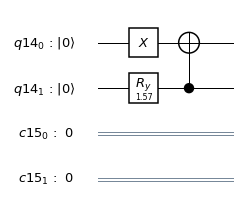

In [24]:
#Testing function on Triplet 0 state
q = QuantumRegister(2)
c = ClassicalRegister(2)
circT = QuantumCircuit(q,c)
circT.x(0)  #flip second qubit
circT.ry(pi/2, 1) #superposes first qubit
circT.cx(q[1],q[0])

densityMatrixComponents(circT,q,c, 10000)
circT.draw(output ='mpl')

In [25]:
#Testing function for 1 qubit
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q)
circ.ry(pi/3,q)
circ.rx(pi,q)

densityMatrixComponents(circ,q,c,10000)

{'X': 0.487, 'Y': 0.007, 'Z': 0.862, 'I': 1}

The following function uses the densityMatrixComponents function to print out the final density matrix for one-qubit and two-qubit systems.

In [26]:
def getDensityMatrix(circuit,q,c):
    components = densityMatrixComponents(circuit,q,c, 50000)
    
    #Pauli operators are stored in a dictionary
    X = np.array([[0.+0.j, 1.+0.j], [1.+0.j, 0.+0.j]])
    Y = np.array([[0.+0.j, 0.-1.j], [0.+1.j, 0.+0.j]])
    Z = np.array([[1.+0.j, 0.+0.j], [0.+0.j, -1.+0.j]])
    I = np.array([[1.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])
    pauli = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    
    densityMatrix = 0
    for i,j in pauli.items():
        if q.size == 1:
            densityMatrix += j*components.get(i)
        else:
            for k,l in pauli.items():
                densityMatrix += np.kron(j, l)*components.get(i+k)
            
    print(np.round_(densityMatrix*(1/2**(q.size)),3))

In [27]:
#Simple one-qubit test
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q)

getDensityMatrix(circ,q,c)

[[0.5+0.j    0.5-0.001j]
 [0.5+0.001j 0.5+0.j   ]]


In [28]:
#One-qubit test
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q)
circ.ry(pi/4,q)
circ.rx(pi,q)

getDensityMatrix(circ,q,c)

[[0.852+0.j    0.356+0.002j]
 [0.356-0.002j 0.148+0.j   ]]


In [29]:
#Comparison with my getDensityMatrix Result
q1 = QuantumRegister(1)
c1 = ClassicalRegister(1)
circ1 = QuantumCircuit(q1,c1)
circ1.h(q1)
circ1.ry(np.pi/4,q1)
circ1.rx(np.pi,q1)

qst_bell = state_tomography_circuits(circ1, q1)
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)

tomo_bell = StateTomographyFitter(job.result(), qst_bell)

print(np.round_(tomo_bell.fit(),3))

[[0.852+0.j    0.356-0.004j]
 [0.356+0.004j 0.148+0.j   ]]


In [30]:
#Test Singlet State
q = QuantumRegister(2)
c = ClassicalRegister(2)
circS = QuantumCircuit(q,c)
circS.x(0)  #flip second qubit
circS.ry(-pi/2, 1) #superposes first qubit
circS.cx(q[1],q[0])

getDensityMatrix(circS,q,c)       

{'10': 24926, '01': 25074}
[[ 0.   +0.j    -0.001+0.j     0.001+0.j     0.   -0.001j]
 [-0.001-0.j     0.5  +0.j    -0.5  +0.001j  0.002-0.002j]
 [ 0.001+0.j    -0.5  -0.001j  0.5  +0.j    -0.002+0.001j]
 [ 0.   +0.001j  0.002+0.002j -0.002-0.001j  0.   +0.j   ]]


In [31]:
#Test Triplet State
q = QuantumRegister(2)
c = ClassicalRegister(2)
circT = QuantumCircuit(q,c)
circT.x(0)  #flip second qubit
circT.ry(pi/2, 1) #superposes first qubit
circT.cx(q[1],q[0])

getDensityMatrix(circT,q,c) 

{'00': 24945, '11': 25055}
[[-0.   +0.j    -0.   +0.002j  0.   -0.002j  0.   +0.001j]
 [-0.   -0.002j  0.5  +0.j     0.5  -0.002j  0.002+0.002j]
 [ 0.   +0.002j  0.5  +0.002j  0.5  +0.j     0.002-0.001j]
 [ 0.   -0.001j  0.002-0.002j  0.002+0.001j  0.   +0.j   ]]
